# Importing Dependencies

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import random
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data preparation

In [10]:
no_tb_data = "TB_Chest_Radiography_Database/Normal"
tb_data = "TB_Chest_Radiography_Database/Tuberculosis"

In [11]:
X_yes = []
for image in tqdm(os.listdir(tb_data)):
    image_path = os.path.join(tb_data, image)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    X_yes.append(img)

100%|██████████| 700/700 [00:05<00:00, 132.42it/s]


In [12]:
x_yes = np.array(X_yes)

In [13]:
# I found that data augmentation for tuberculosis is very important because there is a significant imbalance between normal and tuberculosis data.
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, fill_mode='nearest')

aug_images = []
for image in tqdm(x_yes):  
    image = np.expand_dims(image, axis=0)  
    i = 0
    for batch in datagen.flow(image, batch_size=1):
        aug_images.append(batch[0])  
        i += 1
        if i >= 5:  
            break

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:44<00:00, 15.58it/s]


In [14]:
TB_yes = []
for image in tqdm(aug_images):
    TB_yes.append([image, 1])

100%|██████████| 3500/3500 [00:00<00:00, 292629.75it/s]


In [15]:
X_no = []
for image in tqdm(os.listdir(no_tb_data)):
    image_path = os.path.join(no_tb_data, image)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    X_no.append(img)

100%|██████████| 3500/3500 [00:34<00:00, 100.79it/s]


In [16]:
TB_no = []
for image in tqdm(X_no):
    TB_no.append([image, 0])

100%|██████████| 3500/3500 [00:00<00:00, 1473014.65it/s]


In [17]:
data = TB_yes + TB_no

In [18]:
random.shuffle(data)

In [19]:
X = []
y = []
for i, j in tqdm(data):
    X.append(i)
    y.append(j)

100%|██████████| 7000/7000 [00:00<00:00, 2340571.43it/s]


In [20]:
x = np.array(X)
y = np.array(y)

## Train Data

In [21]:
x_train = x[:5500]
y_train = y[:5500]

## Test Data

In [22]:
x_test = x[5500:7000]
y_test = y[5500:7000]

# Model

In [23]:
model = Sequential()

model.add(Conv2D(100,(3, 3), activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(100,(3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64,(3, 3), activation = "relu"))
#model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64,(3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(.2))
#model.add(Dense(32, activation = "relu"))
model.add(Dropout(.3))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\vedth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training

In [24]:
history = model.fit(x_train, y_train, validation_split= .2, epochs = 5)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 142s 982ms/step - accuracy: 0.6694 - loss: 8.3405 - val_accuracy: 0.9464 - val_loss: 0.2858
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.9062 - loss: 0.3101 - val_accuracy: 0.9673 - val_loss: 0.1815
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 130s 945ms/step - accuracy: 0.9266 - loss: 0.2381 - val_accuracy: 0.9127 - val_loss: 0.2175
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 130s 945ms/step - accuracy: 0.9285 - loss: 0.1969 - val_accuracy: 0.9618 - val_loss: 0.1486
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 130s 942ms/step - accuracy: 0.9588 - loss: 0.1289 - val_accuracy: 0.9773 - val_loss: 0.1066


# Loss and Accuracy 

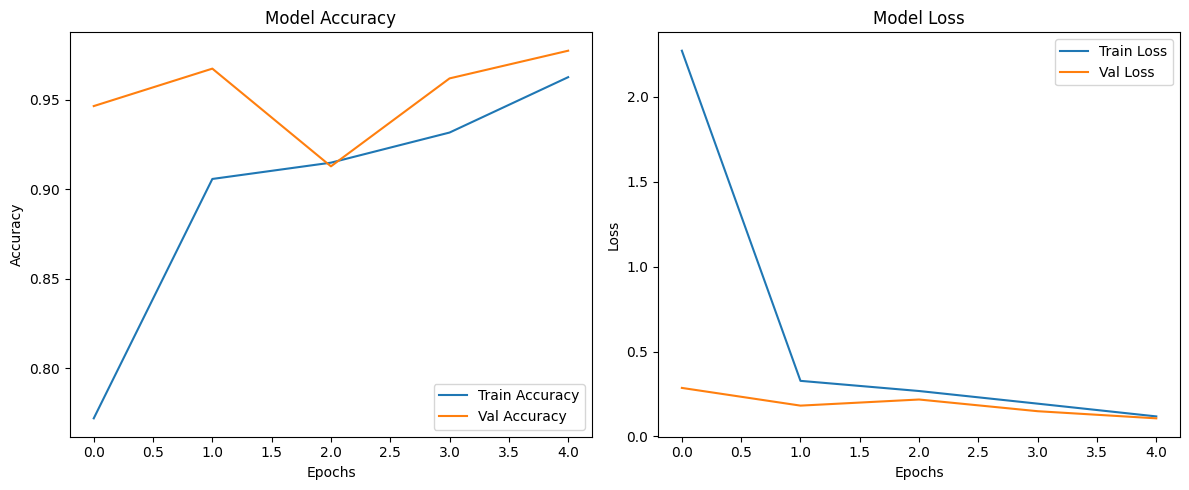

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confution Matrix

In [26]:
threshold = 0.5
y_pred = (model.predict(x_test)>= threshold).astype(int)

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step


<Figure size 1200x1000 with 0 Axes>

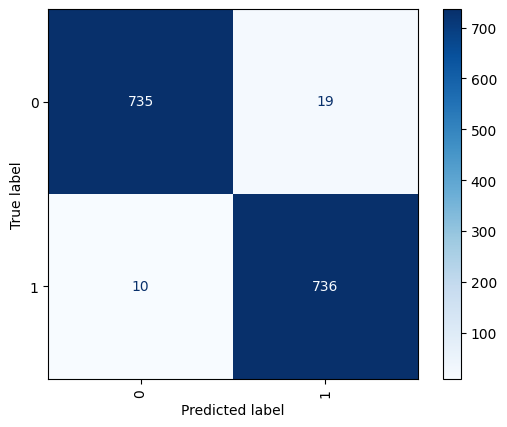

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

# Model Evaluation

In [28]:
model.evaluate(x_test, y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9814 - loss: 0.0919


[0.08744397759437561, 0.9806666374206543]